# Minplus algebra experiment

This code attempts to learn the 2D mixture prior
$J(x) = min(\frac{1}{2t\sigma_{1}}||x-\mu_{1}||^{2}, \frac{1}{2\sigma_{2}}||x-\mu_{2}^{2}||)^{2})$
assuming we have access to training data $\{y_i, S(y_i) = min_{x \in \R} \ \{0.5||x-y_i||^{2}_{2} + J(x)\}\}$.

This is ostensibly the same code as the file in the _hjpdes_experiments_1D folder, except that we use here
the LPN module directly. This is because the experiments in _hjpdes_experiments_1D rely on the utils.py and network.py
files which assume the input is one-dimensional.

## Import modules 

In [17]:
# Import general modules
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

# Import LPN modules
from network import LPN
from utils import prox, cvx, prior

# Set how we compute the prior via an optimization problem
INVERT_MODE = "cvx_cg"

# Set location
MODEL_DIR = "experiments/models/mindplus_2D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# Plotting options
plt.rcParams.update({"text.usetex": True})
sns.set_theme()

Notes: The Euclidean norm function requires something for the tensor gradient... fix this later...

## Parameters, utility functions, and plotting tool

In [32]:
#--- Parameters ---#
# Dimension
dim = 2

# Prior parameters
mu1 = np.array([1.0, 0.0])
mu2 = np.array([1.0, 1.0]/np.sqrt(2.0))
sigma1 = 1.0
sigma2 = 1.0

# LPN model parameters
beta = 10       # beta of softplus
hidden = 50     # number of hidden units
layers = 4      # number of layers



#--- Utility functions ---#
# Euclidean norm
def euclid_norm(x):
    return np.linalg.norm(x, ord = 2, axis = 1)

# Proximal matching loss (-exp(-(x/gamma)^2) + 1) for training the LPN
def exp_func(x, gamma):
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim = 1)/ gamma) ** 2)) + 1.0
    #return -torch.exp(-((euclid_norm(x) / gamma) ** 2)) + 1.0

# Target convex function to train
def cvx_true(y,mu1,mu2,sigma1,sigma2):
    val1 = 0.5*pow(euclid_norm(y-mu1),2)/(1+sigma1)
    val2 = 0.5*pow(euclid_norm(y-mu2),2)/(1+sigma2)
    val = 0.5*pow(euclid_norm(y),2) - np.minimum(val1,val2)
    return val

# Target prior function to learn
def prior_true(y,mu1,mu2,sigma1,sigma2):
    val1 = 0.5*pow(euclid_norm(y-mu1),2)/sigma1
    val2 = 0.5*pow(euclid_norm(y-mu2),2)/sigma2
    val = np.minimum(val1,val2)
    return val


#--- Plotting tool ---#
# 1) This plot the estimated convex and prior functions
# There seems to be an issue with evaluating the prior?
def plot_all(model,a,b,data_points,mu1,mu2,sigma1,sigma2):

    # Create a meshgrid over [a,b]^2 with data_points*3 points
    spacing = data_points*3
    xi = np.linspace(a, b, spacing)
    mesh = np.meshgrid(xi, xi) 
    pts = np.array(mesh).reshape(2, -1).T

    # Compute points along the cross-sections (x1,0) and (0,x2).
    x1_0_points = np.array(np.meshgrid(xi, 0)).reshape(2, -1).T
    x2_0_points = np.array(np.meshgrid(0, xi)).reshape(2, -1).T

    # Compute the true convex and prior functions at these cross-sections
    x1_0_cvx_true = cvx_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    x2_0_cvx_true = cvx_true(x2_0_points,mu1,mu2,sigma1,sigma2)

    x1_0_prior_true = prior_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    x2_0_prior_true = prior_true(x2_0_points,mu1,mu2,sigma1,sigma2)

    # Compute the estimated convex and prior functions at these cross-sections
    x1_0_cvx_est = cvx(x1_0_points,model)
    x2_0_cvx_est = cvx(x2_0_points,model)

    #x1_0_prior_est = prior(x1_0_points,model)
    # x2_0_prior_est = prior(x2_0_points,model)

    # TEST
    test = prox(x1_0_points,model)
    print(test)
    print(x1_0_points)


    # Plot cross section (x1,0) of the convex function
    plt.subplots()
    plt.plot(xi, x1_0_cvx_est, "-", ms=5,label="LPN")
    plt.plot(xi, x1_0_cvx_true, "-", ms=5,label="Ref")
    plt.grid("on")
    plt.title("Cross sections ($x_1$,0) of the convex function")
    plt.xlabel('$x_1$')
    plt.ylabel('Convex functions ($x_1$,0)')
    plt.legend()


    # Plot cross section (0,x2) of the convex function
    plt.subplots()
    plt.plot(xi, x2_0_cvx_est, "-", ms=5,label="LPN")
    plt.plot(xi, x2_0_cvx_true, "-", ms=5,label="Ref")
    plt.grid("on")
    plt.title("Cross sections (0,$x_2$) of the convex function")
    plt.xlabel('$x_2$')
    plt.ylabel('Convex functions (0, $x_2$)')
    plt.legend()


    # Plot cross section (x1,0) of the prior function
    plt.subplots()
    #plt.plot(xi, x1_0_prior_est, "-", label="LPN")
    plt.plot(xi, x1_0_prior_true, "-", label="Ref")
    plt.grid("on")
    plt.title("Cross sections ($x_1$,0) of the prior function")
    plt.xlabel('$x_1$')
    plt.ylabel('Prior functions ($x_1$,0)')
    plt.legend()


    # Plot cross section (0,x2) of the prior function
    plt.subplots()
    #plt.plot(xi, x2_0_prior_est, "-", label="LPN")
    plt.plot(xi, x2_0_prior_true, "-", label="Ref")
    plt.grid("on")
    plt.title("Cross sections (0,$x_2$) of the prior function")
    plt.xlabel('$x_2$')
    plt.ylabel('Prior functions (0, $x_2$)')
    plt.legend()

 
    # # 3D plot of the convex function
    # plt.subplot(1, 2, 1)
    # plt.plot(xi, c, "-", ms=5, label="Cvx func")
    # plt.plot(xi, cvx_true(xi,mu1,mu2,sigma1,sigma2), "--", label="ref.", zorder=1.9)
    # plt.grid("on")
    # plt.legend()
    # plt.title("Cvx func")

    # # 3D plot of the original function
    # plt.subplot(1, 2, 2)
    # plt.plot(xi, p, label="LPN")
    # plt.plot(xi, prior_true(xi,mu1,mu2,sigma1,sigma2), "--", label="ref", zorder=1.9)
    # plt.grid("on")
    # plt.legend()
    # plt.title("Original func")

    # plt.tight_layout()




# Old
# True proximal operator we want to reconstruct
# def prox_true(y,mu1,mu2,sigma1,sigma2):
#     val1 = 0.5*pow(euclid_norm(y-mu1),2)/(1+sigma1)
#     val2 = 0.5*pow(euclid_norm(y-mu2),2)/(1+sigma2)
#     val = (mu1 + sigma1*y)*(val1 <= val2)/(1 + sigma1) + (mu2 + sigma2*y)*(val1 > val2)/(1+sigma2)
#     return val

#y = prox(xi, model)
# # learned prox
# plt.subplot(1, 3, 1)
# plt.plot(xi, y, "-", ms=5, label="LPN")
# plt.plot(xi, prox_true(xi,mu1,mu2,sigma1,sigma2), "--", label="ref.", zorder=1.9)
# plt.grid("on")
# plt.legend()
# plt.title("Learned prox")


# Example: Visualize the target convex and prior functions

Text(0, 0.5, 'prior_true($x_2$,0)')

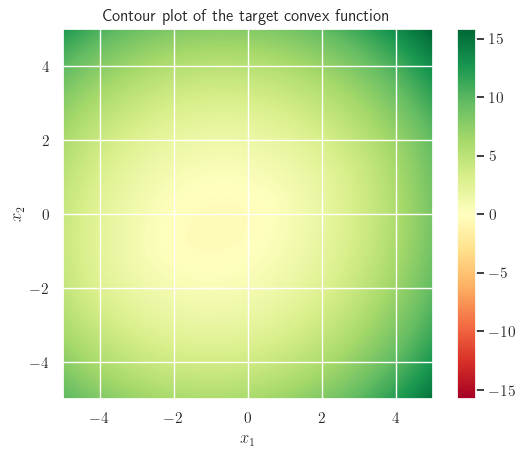

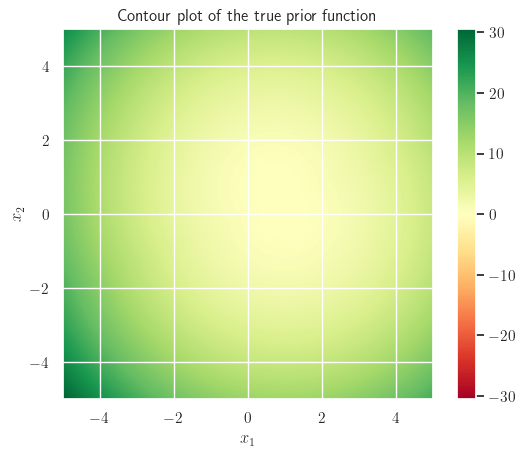

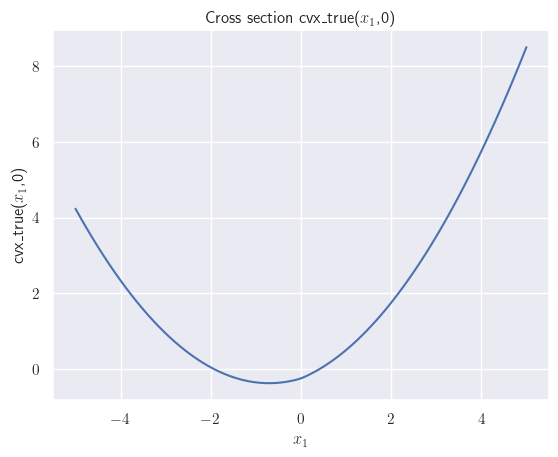

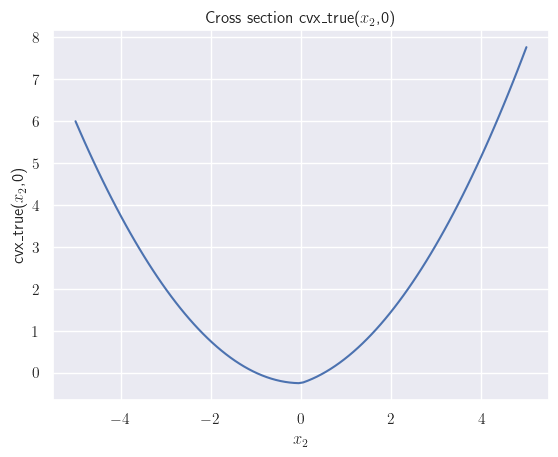

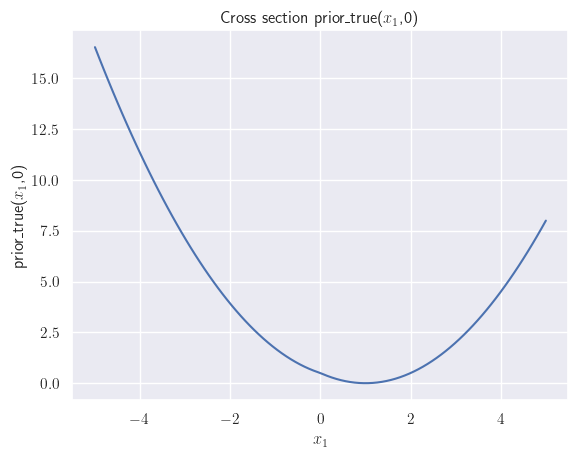

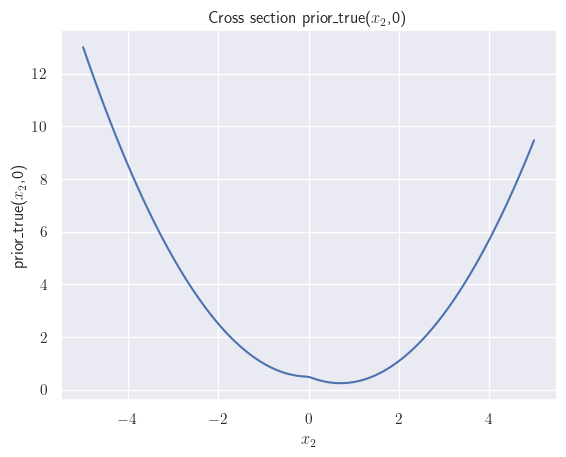

In [19]:
# Generate an [-a, a]^2 square meshgrid
a, spacing = 5, 100
xi = np.linspace(-a, a, spacing)
mesh = np.meshgrid(xi, xi) 

# Recover the list of points as a matrix with 2 columns
pts = np.array(mesh).reshape(2, -1).T

# Evaluate the target convex and prior functions, then reshape them to fit the meshgrid
example_cvx_true = cvx_true(pts,mu1,mu2,sigma1,sigma2).reshape(spacing,-1)
example_prior_true = prior_true(pts,mu1,mu2,sigma1,sigma2).reshape(spacing,-1)

# Plot 2D contours cvx_true(x1,x2) = C
fig1, ax1 = plt.subplots()
im1 = ax1.imshow(example_cvx_true, interpolation='bilinear', cmap=cm.RdYlGn,
               origin='lower', extent=[-a, a, -a, a],
               vmax=abs(example_cvx_true).max(), vmin=-abs(example_cvx_true).max())

plt.title('Contour plot of the target convex function')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.colorbar(im1)

# Plot 2D contours prior_true(x1,x2) = C
fig2, ax2 = plt.subplots()
im2 = ax2.imshow(example_prior_true, interpolation='bilinear', cmap=cm.RdYlGn,
               origin='lower', extent=[-a, a, -a, a],
               vmax=abs(example_prior_true).max(), vmin=-abs(example_prior_true).max())

plt.title('Contour plot of the true prior function')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.colorbar(im2)

# Plot the cross sections cvx_true(x1,0), cvx_true(0,x2), prior_true(x1,0) and prior_true(0,x2)
x1_0_points = np.array(np.meshgrid(xi, 0) ).reshape(2, -1).T
x2_0_points = np.array(np.meshgrid(0, xi) ).reshape(2, -1).T

x1_0_cvx_true = cvx_true(x1_0_points,mu1,mu2,sigma1,sigma2).reshape(spacing,-1)
x2_0_cvx_true = cvx_true(x2_0_points,mu1,mu2,sigma1,sigma2).reshape(spacing,-1)

x1_0_prior_true = prior_true(x1_0_points,mu1,mu2,sigma1,sigma2).reshape(spacing,-1)
x2_0_prior_true = prior_true(x2_0_points,mu1,mu2,sigma1,sigma2).reshape(spacing,-1)

plt.subplots()
plt.plot(xi, x1_0_cvx_true, "-", ms=5)
plt.grid("on")
plt.title("Cross section cvx_true($x_1$,0)")
plt.xlabel('$x_1$')
plt.ylabel('cvx_true($x_1$,0)')

plt.subplots()
plt.plot(xi, x2_0_cvx_true, "-", ms=5)
plt.grid("on")
plt.title("Cross section cvx_true($x_2$,0)")
plt.xlabel('$x_2$')
plt.ylabel('cvx_true($x_2$,0)')

plt.subplots()
plt.plot(xi, x1_0_prior_true, "-", ms=5)
plt.grid("on")
plt.title("Cross section prior_true($x_1$,0)")
plt.xlabel('$x_1$')
plt.ylabel('prior_true($x_1$,0)')

plt.subplots()
plt.plot(xi, x2_0_prior_true, "-", ms=5)
plt.grid("on")
plt.title("Cross section prior_true($x_2$,0)")
plt.xlabel('$x_2$')
plt.ylabel('prior_true($x_2$,0)')

## Generate training data

In [20]:
# Generate samples {yi} uniformly in the square [-a,a]
a = -4
b = 4
data_points = 200

input = np.zeros((2,data_points))
input[0] = np.random.uniform(a,b,data_points)
input[1] = np.random.uniform(a,b,data_points)
input = input.reshape(data_points,2)

# Generate data cvx_true(yi)
cvx_samples = cvx_true(input,mu1,mu2,sigma1,sigma2).reshape(data_points,-1)

# Recast and samples as tensors
input = torch.from_numpy(input).float()
cvx_samples = torch.from_numpy(cvx_samples).float()

## Training function

In [21]:
def single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss=None):
    # Compute the convex function from the input
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points   # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 500:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [22]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer, loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-4
for i in range(20000):
    single_iteration(i, data_points, lpn_model, optimizer, loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

iteration 0 loss 10.50808334350586
iteration 0 loss 130.3355255126953
iteration 500 loss 2.227349042892456
iteration 1000 loss 0.757061243057251
iteration 1500 loss 0.5898397564888
iteration 2000 loss 0.5328013896942139
iteration 2500 loss 0.4735018014907837
iteration 3000 loss 0.4017585813999176
iteration 3500 loss 0.31941017508506775
iteration 4000 loss 0.2326643019914627
iteration 4500 loss 0.1518423706293106
iteration 5000 loss 0.08567104488611221
iteration 5500 loss 0.04386099427938461
iteration 6000 loss 0.022967195138335228
iteration 6500 loss 0.013090788386762142
iteration 7000 loss 0.00836945977061987
iteration 7500 loss 0.005734595004469156
iteration 8000 loss 0.00414876826107502
iteration 8500 loss 0.0030682808719575405
iteration 9000 loss 0.0022712773643434048
iteration 9500 loss 0.001696828636340797
iteration 10000 loss 0.001267809304408729
iteration 10500 loss 0.0009440937428735197
iteration 11000 loss 0.0006983926286920905
iteration 11500 loss 0.0005093366489745677
itera

L2 loss -- Plot

[[-1.6357386   0.35398513]
 [-1.6271651   0.35395518]
 [-1.6186714   0.35393894]
 ...
 [ 2.4401402  -0.00760217]
 [ 2.446072   -0.00665924]
 [ 2.451974   -0.005701  ]]


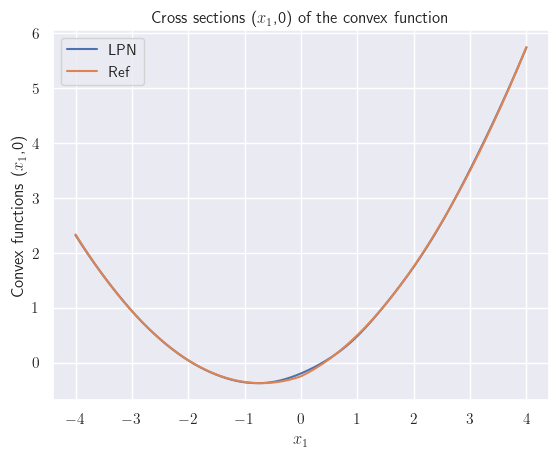

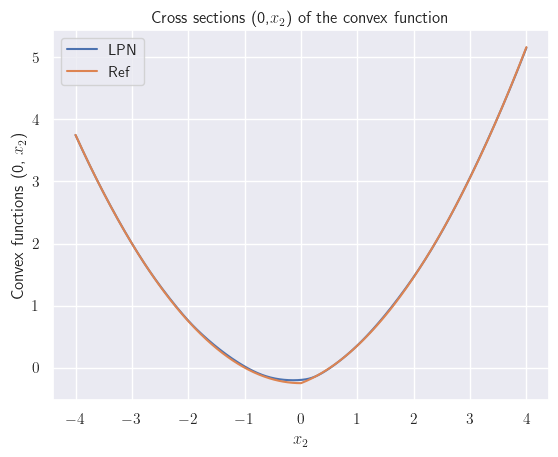

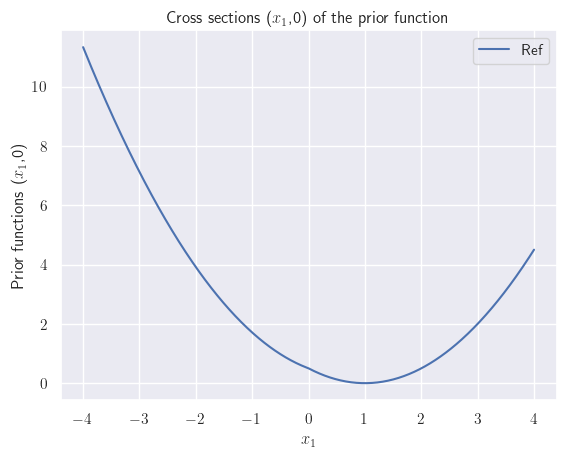

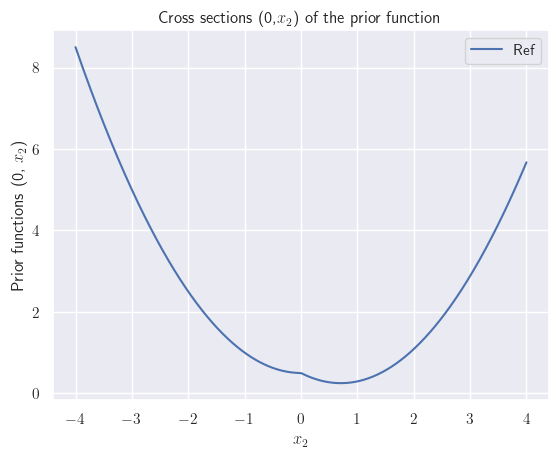

In [33]:
plot_all(lpn_model,a,b,data_points,mu1,mu2,sigma1,sigma2)

L1 loss -- Train

In [24]:
# # initialize
# lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
# optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

# loss_type = 1

# for i in range(1):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type)

# for g in optimizer.param_groups:
#     g["lr"] = 1e-4
# for i in range(20000):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type)


# # save the model
# torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l1.pth"))

L1 loss -- Plot

In [25]:
# plot_all(lpn_model,a,b,data_points,mu1,mu2,sigma1,sigma2)

Proximal matching loss.
We perform proximal matching loss with a decreasing sequence of gamma parameters.

gamma = 10 -- Train

In [26]:
# lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
# optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

# loss_type = 0
# gamma_loss = 10

# # set learning rate
# for g in optimizer.param_groups:
#     g["lr"] = 1e-3

# for i in range(3000):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

# for g in optimizer.param_groups:
#     g["lr"] = 1e-4

# for i in range(3000):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

# torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

gamma = 10 -- Plot

In [27]:
# plot_all(lpn_model,a,b,data_points,mu1,mu2,sigma1,sigma2)

gamma = 5 -- Train

In [28]:
# gamma_loss = 5

# for g in optimizer.param_groups:
#     g["lr"] = 1e-4

# for i in range(6000):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

# torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

gamma = 5 -- Plot

In [29]:
# plot_all(lpn_model,a,b,data_points,mu1,mu2,sigma1,sigma2)

gamma = 1 -- Train

In [30]:
# gamma_loss = 1

# for g in optimizer.param_groups:
#     g["lr"] = 1e-5

# for i in range(10000):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

# torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

gamma = 1 -- Plot

In [31]:
# plot_all(lpn_model,a,b,data_points,mu1,mu2,sigma1,sigma2)